In [1]:
# Compute the camera calibration matrix and distortion coefficients
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Object and Image points for camera calibration
nx = 9
ny = 6
objpoints = []
imgpoints = []

objp = np.zeros((nx * ny, 3), np.float32)
objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

imgs = glob.glob('camera_cal/calibration*.jpg')
for fn in imgs:
    # Read each chessboard image
    img = cv2.imread(fn)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)


In [2]:
# Plot images utilities
def plot_images(imgs, titles, points=None):
    rows = len(imgs)
    cols = len(imgs[0])
    f, axs = plt.subplots(rows, cols, figsize=(24, 9))
    f.tight_layout()
    
    if rows == 1:
        for i in range(cols):
            axs[i].imshow(imgs[0][i], cmap='gray')
            axs[i].set_title(titles[0][i], fontsize=20)
            if points:
                axs[i].plot(points[0][i][:,0], points[0][i][:,1], 'r')
    else:
        for i in range(rows):
            for j in range(len(imgs[i])):
                axs[i][j].imshow(imgs[i][j], cmap='gray')
                axs[i][j].set_title(titles[i][j], fontsize=20)
                if points:
                    axs[i][j].plot(points[i][j][:,0], points[i][j][:,1], 'r')
    plt.subplots_adjust(left=0., right=1, top=1.1, bottom=0.)

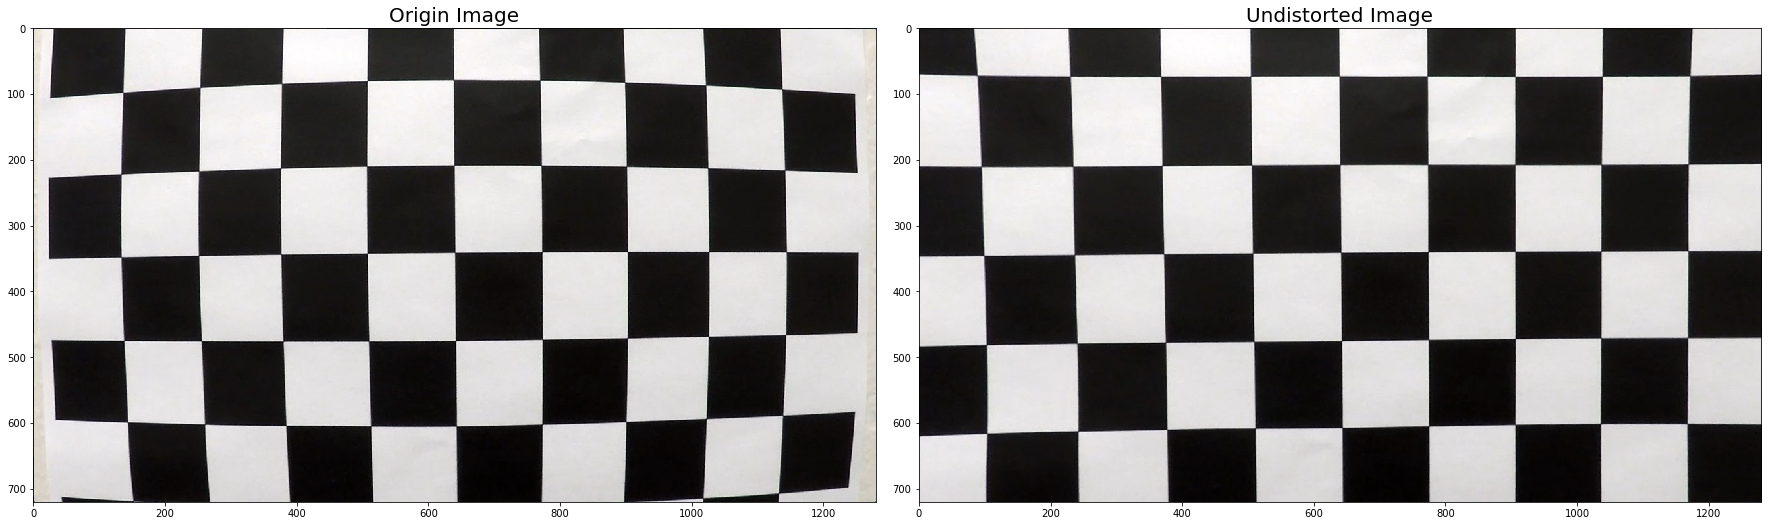

In [3]:
# Test calibration on calibration1.jpg, because it's not used by calibration with different ny(=5)
img = mpimg.imread('camera_cal/calibration1.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

plot_images([ [img, dst] ], [ ['Origin Image', 'Undistorted Image'] ])

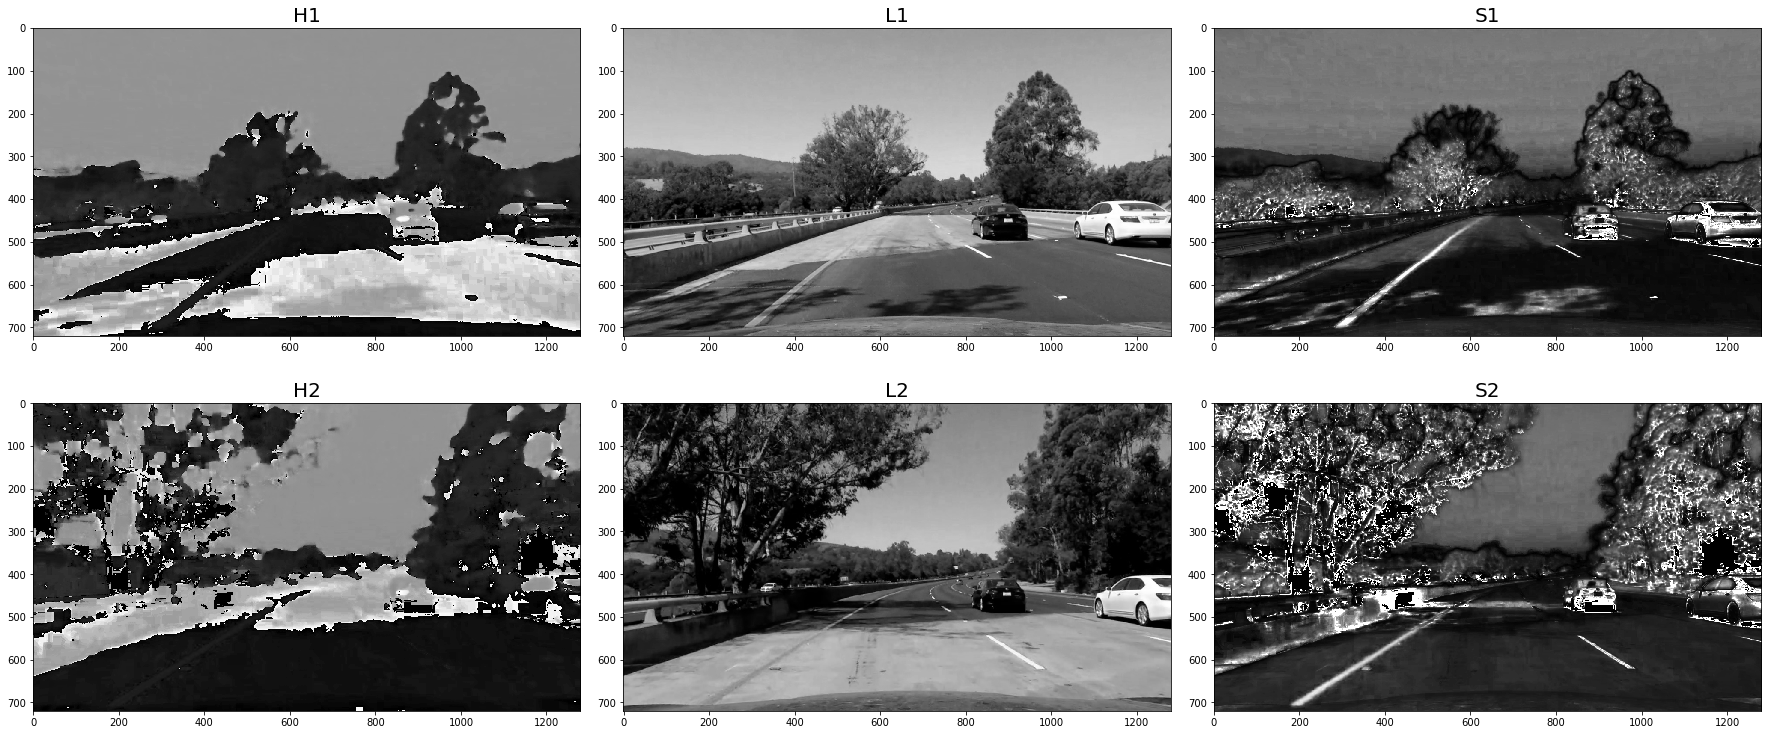

In [4]:
""" 
    Step 3: Use color transforms, gradients, etc., to create a thresholded binary image.
"""
def undist(img):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    return cv2.undistort(img, mtx, dist, None, mtx)

# Show h,l,s channels for 2 tricky images test4.jpg and test5.jpg
dst1 = undist(mpimg.imread('test_images/test4.jpg'))
hls1 = cv2.cvtColor(dst1, cv2.COLOR_RGB2HLS)
H1, L1, S1 = hls1[:,:,0], hls1[:,:,1], hls1[:,:,2]
dst2 = undist(mpimg.imread('test_images/test5.jpg'))
hls2 = cv2.cvtColor(dst2, cv2.COLOR_RGB2HLS)
H2, L2, S2 = hls2[:,:,0], hls2[:,:,1], hls2[:,:,2]

plot_images([ [H1, L1, S1], [H2, L2, S2] ], [ ['H1', 'L1', 'S1'], ['H2', 'L2', 'S2'] ])

In [5]:
# Gradient operations
def sobel_xy(img, orient='x', kernel=3, thresh=(20, 100)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel))
    if orient == 'y':
        sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel))
    # Rescale back to 8 bit integer
    sobel = np.uint8(255*sobel/np.max(sobel))
    # Create a copy and apply the threshold
    binary = np.zeros_like(sobel)
    binary[(sobel >= thresh[0]) & (sobel <= thresh[1])] = 1
    return binary

def sobel_mag(img, kernel=9, thresh=(30, 100)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel)
    # Calculate the gradient magnitude
    mag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    mag = np.uint8(255*mag/np.max(mag))
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary = np.zeros_like(mag)
    binary[(mag >= thresh[0]) & (mag <= thresh[1])] = 1
    return binary

def sobel_dir(img, kernel=15, thresh=(0.7, 1.3)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel)
    direct = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary = np.zeros_like(direct, dtype=np.uint8)
    binary[(direct >= thresh[0]) & (direct <= thresh[1])] = 1
    return binary


In [6]:
# So S-channel is a better start for combining with gradients
# R: (200, 255), S: (90, 255), H: (15, 100), Gray: (180, 255)
# Get binary applied thresh in s_channel
def s_channel(img, thresh = (90, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary

def h_channel(img, thresh = (15, 100)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    binary = np.zeros_like(H)
    binary[(H > thresh[0]) & (H <= thresh[1])] = 1
    return binary

def r_channel(img, thresh = (200, 255)):
    R = img[:,:,0]
    binary = np.zeros_like(R)
    binary[(R > thresh[0]) & (R <= thresh[1])] = 1
    return binary

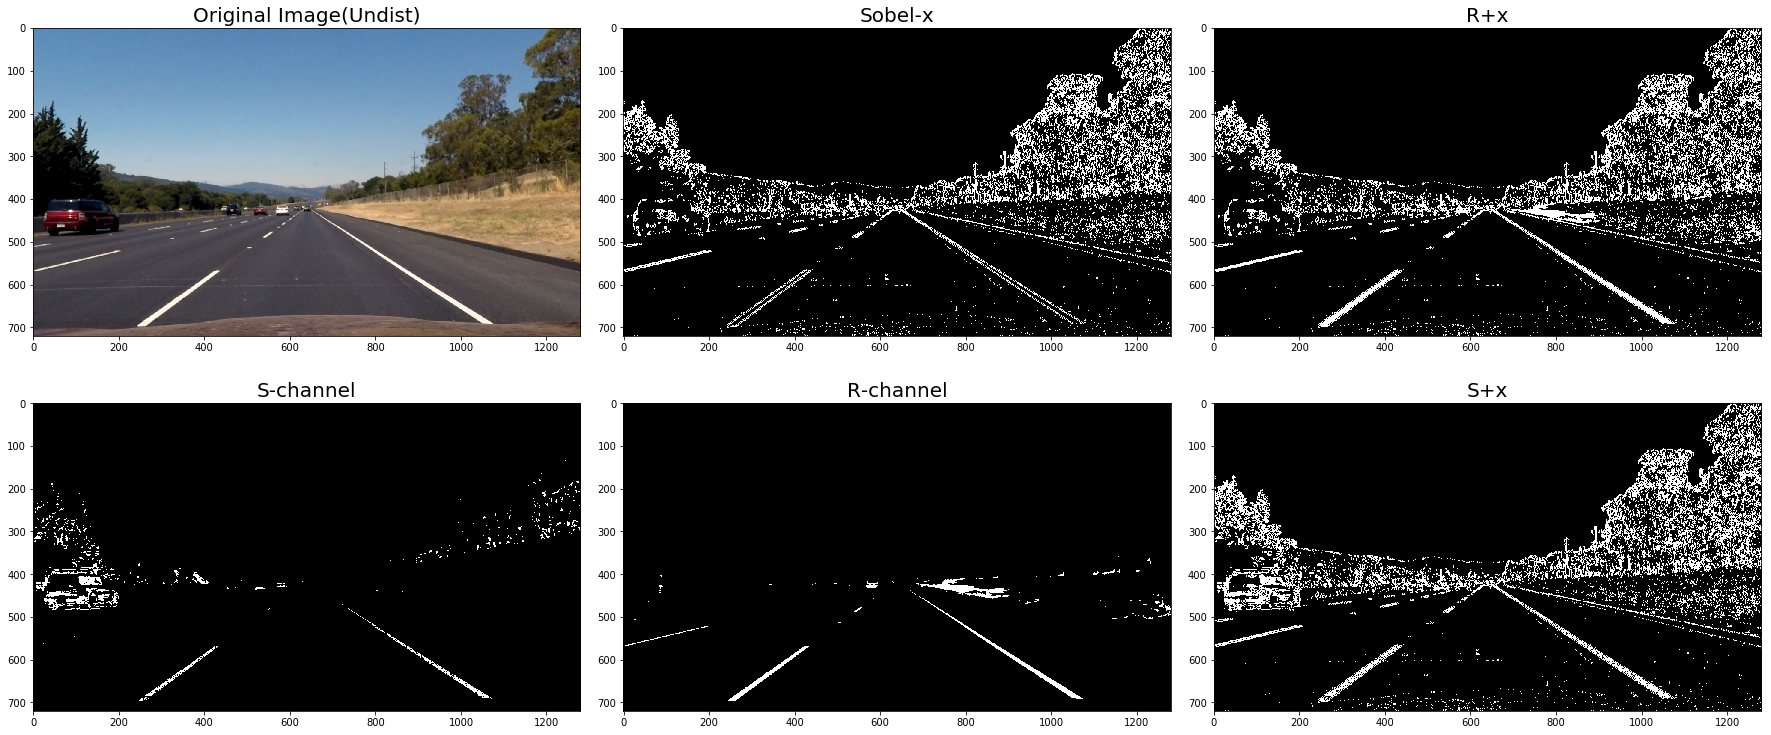

In [7]:
img = undist(mpimg.imread('test_images/straight_lines2.jpg'))
sobelx = sobel_xy(img, thresh=(10, 100))
#mag = sobel_mag(img, thresh=(10, 100))
#dirt = sobel_dir(img, thresh=(0.7, 1.3))
schn = s_channel(img, thresh=(200, 255))
#hchn = h_channel(img, thresh=(15, 100))
rchn = r_channel(img, thresh=(210, 255))

# sobel-x + R-channel
com = np.zeros_like(schn)
com[(rchn == 1) | (sobelx == 1)] = 1

# sobel-x + S-channel
com2 = np.zeros_like(schn)
com2[(schn == 1) | (sobelx == 1)] = 1

plot_images([ [img, sobelx, com], [schn, rchn, com2] ], \
            [ ['Original Image(Undist)', 'Sobel-x', 'R+x'], [ 'S-channel', 'R-channel', 'S+x'] ])

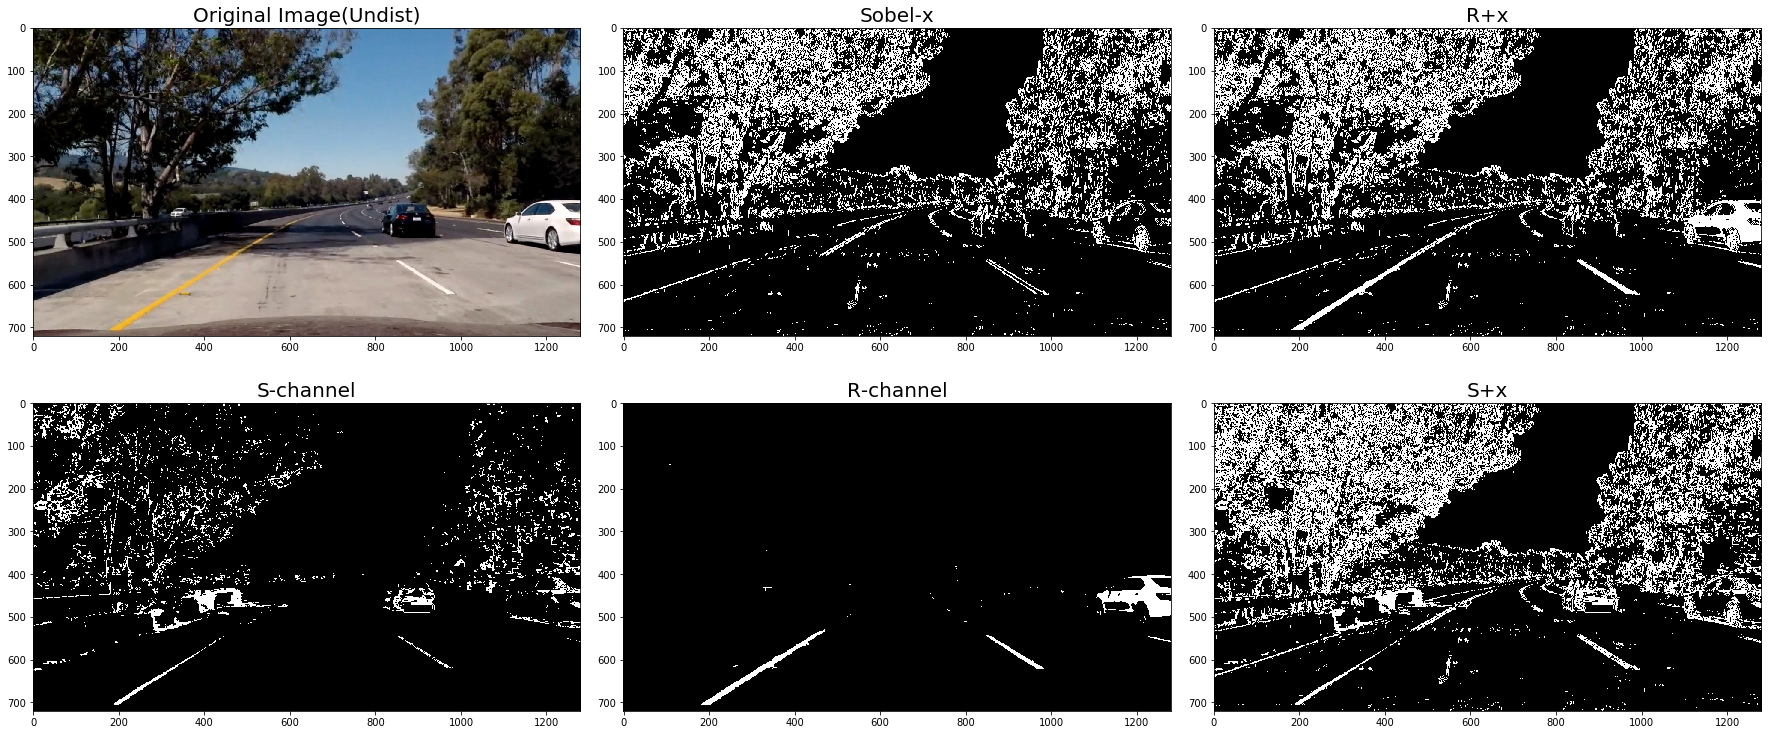

In [8]:
img = undist(mpimg.imread('test_images/test5.jpg'))
sobelx = sobel_xy(img, thresh=(10, 100))
#mag = sobel_mag(img, thresh=(10, 100))
#dirt = sobel_dir(img, thresh=(0.7, 1.3))
schn = s_channel(img, thresh=(200, 255))
#hchn = h_channel(img, thresh=(15, 100))
rchn = r_channel(img, thresh=(210, 255))

# sobel-x + R-channel
com = np.zeros_like(schn)
com[(rchn == 1) | (sobelx == 1)] = 1

# sobel-x + S-channel
com2 = np.zeros_like(schn)
com2[(schn == 1) | (sobelx == 1)] = 1

plot_images([ [img, sobelx, com], [schn, rchn, com2] ], \
            [ ['Original Image(Undist)', 'Sobel-x', 'R+x'], [ 'S-channel', 'R-channel', 'S+x'] ])

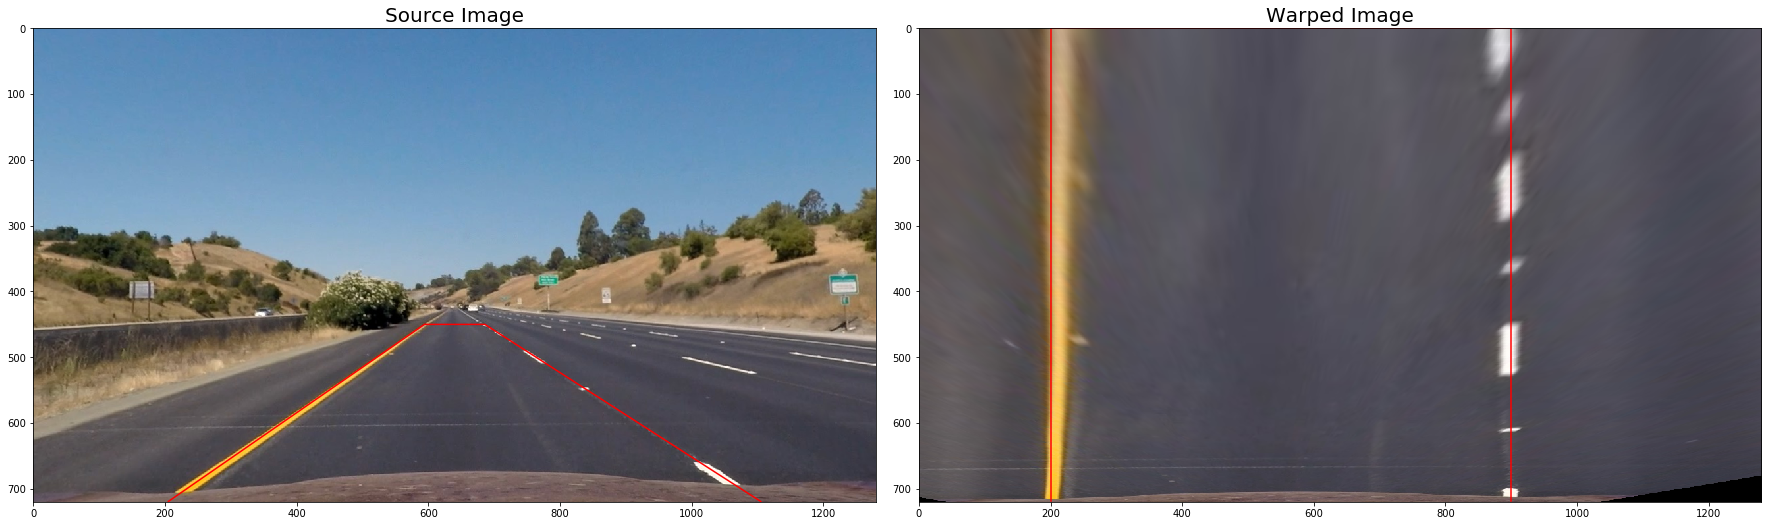

In [9]:
"""
    Step 4. Apply a perspective transform to rectify binary image ("birds-eye view").
    # Define conversions in x and y from pixels space to meters(35. Measuring Curvature)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
"""
def warpMtx():
    src = np.float32([ [205, 719], [594, 450], [686, 450], [1105, 719] ])
    dst = np.float32([ [200, 719], [200, 0], [900, 0], [900, 719] ])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv, src, dst

img = undist(mpimg.imread('test_images/straight_lines1.jpg'))
img_size = (img.shape[1], img.shape[0])
M, Minv, src, dst = warpMtx()
warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

plot_images([ [img, warped] ], [ ['Source Image', 'Warped Image'] ], [ [src, dst] ])

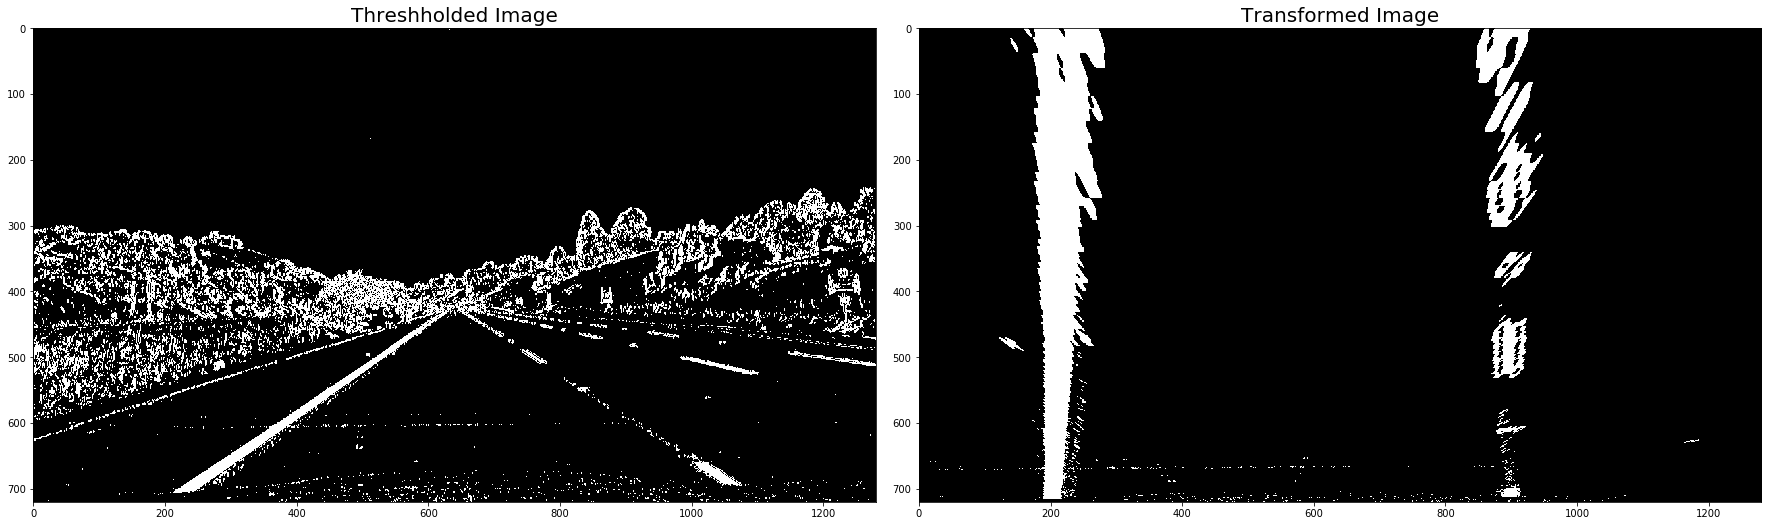

In [10]:
def combine(img):
    img = undist(img)
    sobelx = sobel_xy(img, thresh=(10, 100))
    #schn = s_channel(img, thresh=(200, 255))
    rchn = r_channel(img, thresh=(210, 255))

    # R-channel +　sobel-x
    com = np.zeros_like(rchn)
    com[(rchn == 1) | (sobelx == 1)] = 1

    return com

img = combine(mpimg.imread('test_images/straight_lines1.jpg'))
warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
plot_images([ [img, warped] ], [ ['Threshholded Image', 'Transformed Image'] ])

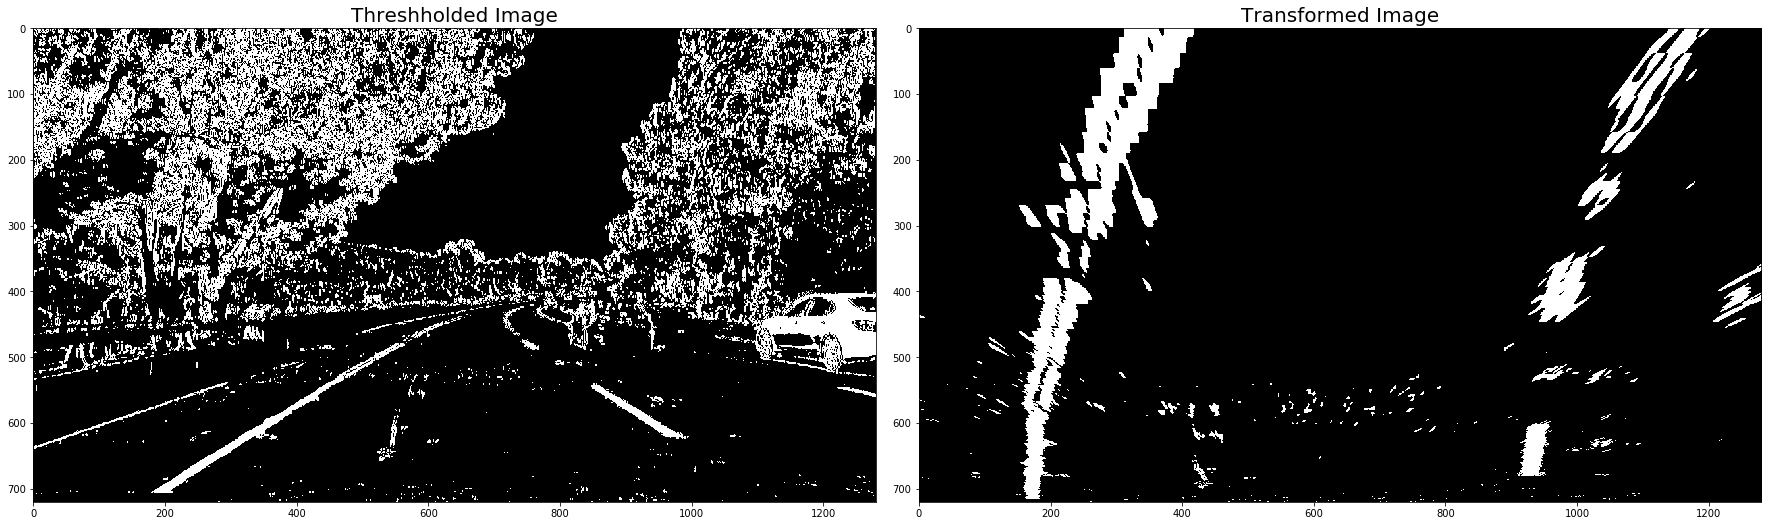

In [11]:
img = combine(mpimg.imread('test_images/test5.jpg'))
warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
plot_images([ [img, warped] ], [ ['Threshholded Image', 'Transformed Image'] ])

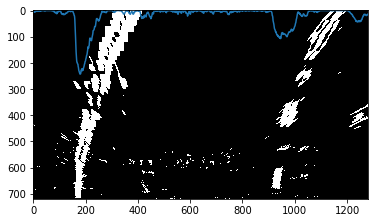

In [12]:
hist = np.sum(warped[int(warped.shape[0]/2):,:], axis=0)
plt.imshow(warped, cmap='gray')
plt.plot(hist)

(720, 0)

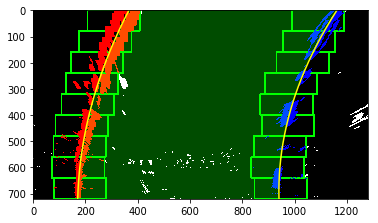

In [16]:

hist = np.sum(warped[int(warped.shape[0]/2):,:], axis=0)
out_img = np.dstack((warped, warped, warped)) * 255
midpoint = np.int(hist.shape[0]/2)
leftx_base = np.argmax(hist[:midpoint])
rightx_base = np.argmax(hist[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = warped.shape[0] - (window+1)*window_height
    win_y_high = warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 5) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 5) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
                      (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
                       (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

## Draw Lane
lane_img = np.zeros_like(out_img)
left_line = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
right_line = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
lane_pts = np.hstack((left_line, right_line))
cv2.fillPoly(lane_img, np.int_([lane_pts]), (0, 255, 0))

result = cv2.addWeighted(out_img, 1, lane_img, 0.3, 0)

plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

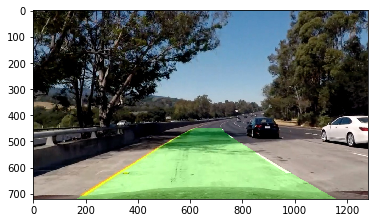

In [19]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

undist_img = undist(mpimg.imread('test_images/test5.jpg'))
# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (undist_img.shape[1], undist_img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
plt.imshow(result)